<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

url = "https://raw.githubusercontent.com/snipsco/nlu-benchmark/master/2016-12-built-in-intents/benchmark_data.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print("Successfully fetched SNIPS dataset")

    snips_data = {}
    for domain in data["domains"]:
        for intent in domain["intents"]:
            intent_name = intent["benchmark"]["Snips"]["original_intent_name"]
            queries = [query["text"] for query in intent["queries"]]
            if intent_name in snips_data:
                snips_data[intent_name].extend(queries)
            else:
                snips_data[intent_name] = queries

    print(f"Total intents: {len(snips_data)}")
    example_intent = list(snips_data.keys())[0]
    print("Example intent:", example_intent)
    print("Example queries:", snips_data[example_intent][:5])
else:
    raise Exception("Failed to fetch SNIPS dataset")

Successfully fetched SNIPS dataset
Total intents: 10
Example intent: ShareCurrentLocation
Example queries: ["Share my location with Hillary's sister", 'Send my current location to my father', 'Share my current location with Jim', 'Send my location to my husband', 'Send my location']


In [2]:
#preprocessing data
#convert the dictionary into a list of (query, intent) pairs.
data_samples = []
for intent, queries in snips_data.items():
    for query in queries:
        data_samples.append((query, intent))
print(f"Total samples: {len(data_samples)}")

def build_vocab(data, min_freq=1):
    from collections import Counter
    counter = Counter()
    for sentence, _ in data:
        tokens = sentence.lower().split()
        counter.update(tokens)
    #reserve 0 for padding and 1 for unknown tokens.
    vocab = {"<pad>": 0, "<unk>": 1}
    idx = 2
    for token, count in counter.items():
        if count >= min_freq:
            vocab[token] = idx
            idx += 1
    return vocab

vocab = build_vocab(data_samples, min_freq=5)
print("Vocabulary size:", len(vocab))

#build label mapping
intent_names = sorted({intent for _, intent in data_samples})
label2idx = {label: i for i, label in enumerate(intent_names)}
idx2label = {i: label for label, i in label2idx.items()}
print("Intent labels mapping:", label2idx)

Total samples: 328
Vocabulary size: 110
Intent labels mapping: {'BookRestaurant': 0, 'ComparePlaces': 1, 'GetDirections': 2, 'GetPlaceDetails': 3, 'GetTrafficInformation': 4, 'GetWeather': 5, 'RequestRide': 6, 'SearchPlace': 7, 'ShareCurrentLocation': 8, 'ShareETA': 9}


In [3]:
class SnipsDataset(Dataset):
    def __init__(self, data, vocab, label2idx):
        self.data = data
        self.vocab = vocab
        self.label2idx = label2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        query, intent = self.data[idx]
        tokens = query.lower().split()
        token_ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
        return torch.tensor(token_ids, dtype=torch.long), self.label2idx[intent]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=vocab["<pad>"])
    return padded, torch.tensor(labels, dtype=torch.long), lengths

#train test split
dataset = SnipsDataset(data_samples, vocab, label2idx)
num_samples = len(dataset)
num_train = int(0.8 * num_samples)
num_test = num_samples - num_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_test])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 num_layers=1, bidirectional=True, dropout=0.3):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<pad>"])
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=bidirectional, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        fc_in_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_in_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        # store hidden dimensions and num layers
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)

        # pack embedded sequence for lstm
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                            batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        # get final hidden state
        if self.rnn.bidirectional:
            hidden = hidden.view(self.num_layers, 2, x.size(0), self.hidden_dim)
            hidden_last = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1)
        else:
            hidden_last = hidden[-1]

        # apply dropout and fcl
        hidden_last = self.dropout(hidden_last)
        output = self.fc(hidden_last)
        return output

In [5]:
# hyperparameters
embedding_dim = 50
hidden_dim = 128
output_dim = len(label2idx)
num_layers = 1
bidirectional = True
dropout = 0.3

model = RNNClassifier(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      output_dim=output_dim,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      dropout=dropout)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RNNClassifier(
  (embedding): Embedding(110, 50, padding_idx=0)
  (rnn): LSTM(50, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [6]:
def train_model(model, train_loader, device, num_epochs=15, lr=0.0006, weight_decay=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        all_preds, all_labels = [], []

        for batch in train_loader:
            x, y, lengths = batch
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)

            optimizer.zero_grad()
            outputs = model(x, lengths)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

        train_loss = epoch_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.2f}%")

    return train_losses, train_accuracies

In [7]:
def evaluate_model(model, test_loader, device, intent_names, idx2label):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    global all_test_preds, all_test_labels
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            x, y, lengths = batch
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            outputs = model(x, lengths)
            loss = criterion(outputs, y)
            test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(y.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = accuracy_score(all_test_labels, all_test_preds)
    print(f"\nFinal Test Loss = {test_loss:.4f}, Test Acc = {test_acc*100:.2f}%")

In [8]:
train_losses, train_accuracies = train_model(model, train_loader, device)
evaluate_model(model, test_loader, device, intent_names, idx2label)

Epoch 01: Train Loss = 2.2593, Train Acc = 17.18%
Epoch 02: Train Loss = 2.0932, Train Acc = 35.50%
Epoch 03: Train Loss = 1.8905, Train Acc = 41.60%
Epoch 04: Train Loss = 1.6437, Train Acc = 47.33%
Epoch 05: Train Loss = 1.4845, Train Acc = 54.96%
Epoch 06: Train Loss = 1.2816, Train Acc = 64.12%
Epoch 07: Train Loss = 1.0469, Train Acc = 71.37%
Epoch 08: Train Loss = 0.8620, Train Acc = 76.34%
Epoch 09: Train Loss = 0.7360, Train Acc = 79.77%
Epoch 10: Train Loss = 0.6355, Train Acc = 83.21%
Epoch 11: Train Loss = 0.5368, Train Acc = 85.11%
Epoch 12: Train Loss = 0.3948, Train Acc = 91.22%
Epoch 13: Train Loss = 0.3611, Train Acc = 92.75%
Epoch 14: Train Loss = 0.3291, Train Acc = 92.37%
Epoch 15: Train Loss = 0.3274, Train Acc = 91.60%

Final Test Loss = 0.7585, Test Acc = 75.76%



Classification Report:
                       precision    recall  f1-score   support

       BookRestaurant       0.91      0.77      0.83        13
        ComparePlaces       0.40      0.50      0.44         4
        GetDirections       0.82      0.75      0.78        12
      GetPlaceDetails       0.78      0.70      0.74        10
GetTrafficInformation       1.00      1.00      1.00         2
           GetWeather       0.67      0.80      0.73         5
          RequestRide       0.80      0.57      0.67         7
          SearchPlace       0.50      0.83      0.62         6
 ShareCurrentLocation       1.00      1.00      1.00         4
             ShareETA       1.00      1.00      1.00         3

             accuracy                           0.76        66
            macro avg       0.79      0.79      0.78        66
         weighted avg       0.79      0.76      0.76        66



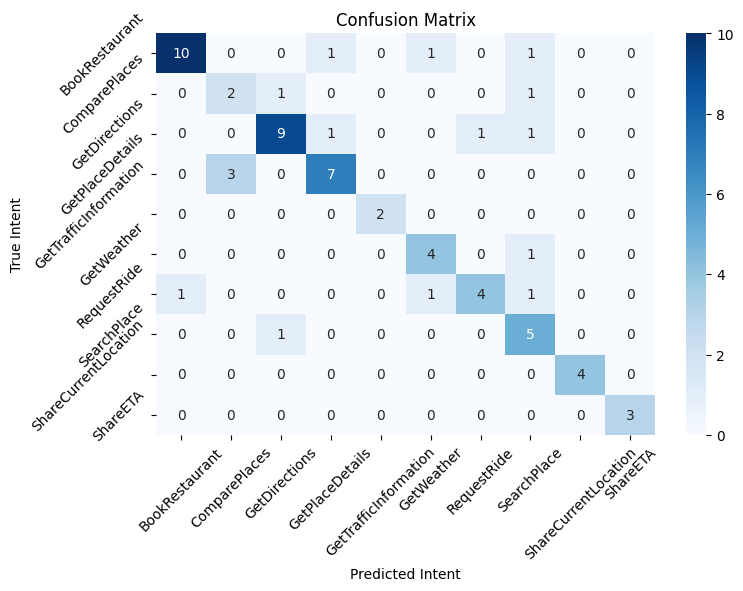

Correctly Classified:
1. True: ShareCurrentLocation, Predicted: ShareCurrentLocation
2. True: RequestRide, Predicted: RequestRide
3. True: GetDirections, Predicted: GetDirections
4. True: ShareETA, Predicted: ShareETA
5. True: RequestRide, Predicted: RequestRide
6. True: BookRestaurant, Predicted: BookRestaurant
7. True: SearchPlace, Predicted: SearchPlace
8. True: SearchPlace, Predicted: SearchPlace
9. True: GetPlaceDetails, Predicted: GetPlaceDetails
10. True: GetWeather, Predicted: GetWeather
11. True: GetDirections, Predicted: GetDirections
12. True: SearchPlace, Predicted: SearchPlace
13. True: GetDirections, Predicted: GetDirections
14. True: BookRestaurant, Predicted: BookRestaurant
15. True: BookRestaurant, Predicted: BookRestaurant
16. True: BookRestaurant, Predicted: BookRestaurant
17. True: BookRestaurant, Predicted: BookRestaurant
18. True: GetDirections, Predicted: GetDirections
19. True: BookRestaurant, Predicted: BookRestaurant
20. True: GetWeather, Predicted: GetWeather

In [9]:
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=intent_names))

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=intent_names, yticklabels=intent_names)
plt.xlabel("Predicted Intent")
plt.ylabel("True Intent")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
correct_predictions = []
incorrect_predictions = []

# Collect correct and incorrect predictions into respective lists
for true, pred in zip(all_test_labels, all_test_preds):
    if true == pred:
        correct_predictions.append((true, pred))
    else:
        incorrect_predictions.append((true, pred))

# Print correct predictions first
print("Correctly Classified:")
for idx, (true, pred) in enumerate(correct_predictions, start=1):
    print(f"{idx}. True: {idx2label[true]}, Predicted: {idx2label[pred]}")

# Print incorrect predictions afterwards
print("\nIncorrectly Classified:")
for idx, (true, pred) in enumerate(incorrect_predictions, start=1):
    print(f"{idx}. True: {idx2label[true]}, Predicted: {idx2label[pred]}")

In [10]:
import pickle

with open("vocab.pickle", "wb") as f:
    pickle.dump(vocab, f)
print("Saved vocab.pickle")

with open("intent_labels.pickle", "wb") as f:
    pickle.dump(label2idx, f)
print("Saved intent_labels.pickle")

torch.save(model.state_dict(), "CVNL_RNN.pth")
print("Saved CVNL_RNN.pth")


Saved vocab.pickle
Saved intent_labels.pickle
Saved CVNL_RNN.pth
